In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#load data
df_raw= pd.read_csv("food-prices-for-nigeria-2017-2021.csv")
df_raw.head()

,ItemLabels,Jan-17,Feb-17,Mar-17,Apr-17,May-17,Jun-17,Jul-17,Aug-17,Sep-17,...,Jun-21,Jul-21,Aug-21,Sep-21,Oct-21,Nov-21,Lowest,Highest,Month-on-Month,Year-on-Year
0,Agric eggs medium size,512.99,520.16,507.69,518.66,522.71,514.66,498.50,485.19,487.51,...,556.47,577.55,585.64,604.99,614.89,629.82,Borno (411.67),Bayelsa (800),2.43,27.31
1,Agric eggs(medium size price of one),47.42,42.90,43.93,46.22,45.73,45.28,44.32,42.92,45.72,...,51.22,52.73,53.20,54.62,55.49,57.35,Taraba (41.51),Ogun (70.06),3.35,28.15
2,"Beans brown,sold loose",353.60,337.11,353.28,357.19,365.86,374.26,382.35,370.25,404.84,...,471.24,485.44,496.03,492.13,478.76,490.19,Bauchi (234.29),Anambra (899.4),2.39,46.47
3,Beans:white black eye. sold loose,305.53,309.85,318.45,324.04,332.28,339.64,343.96,335.71,358.13,...,431.79,444.21,457.98,461.59,464.74,476.76,Bauchi (235.22),Ebonyi (887.77),2.59,54.61
4,Beef Bone in,1001.24,995.65,1010.29,1035.45,1123.65,1129.02,1128.94,1151.38,1078.49,...,1220.33,1262.10,1274.20,1320.73,1339.77,1366.24,Taraba (975.2),Abuja (1885.99),1.98,26.37


In [4]:
#create new df to hold cleaned dataset
df_clean = df_raw.copy()
# drop useless columns

df_clean = df_clean.drop(columns=["Month-on-Month","Year-on-Year","Lowest","Highest"],axis=1)

# Reshape: Melt wide to long
df_clean = df_clean.melt(
    id_vars='ItemLabels',
    var_name='Date',
    value_name='Price'
)

#view new shape
df_clean.head()

,ItemLabels,Date,Price
0,Agric eggs medium size,Jan-17,512.99
1,Agric eggs(medium size price of one),Jan-17,47.42
2,"Beans brown,sold loose",Jan-17,353.60
3,Beans:white black eye. sold loose,Jan-17,305.53
4,Beef Bone in,Jan-17,1001.24


In [5]:
#rename itemlabels to item. not neccessary, just my preference
df_clean = df_clean.rename(columns={"ItemLabels":"Item"})
df_clean.head()

,Item,Date,Price
0,Agric eggs medium size,Jan-17,512.99
1,Agric eggs(medium size price of one),Jan-17,47.42
2,"Beans brown,sold loose",Jan-17,353.60
3,Beans:white black eye. sold loose,Jan-17,305.53
4,Beef Bone in,Jan-17,1001.24


In [6]:
#check nulls
df_clean.isnull().sum()

#clean null columns

#drop nulls in item columns, as if there's no item, the row is useless since we're predicting prices of items
df_clean = df_clean.dropna(subset=["Item"])

#check nulls in price
df_clean[df_clean['Price'].isnull()]
#footer text from data file makes up the nulls in price, so we drop them

df_clean = df_clean.dropna(subset=['Price'])
df_clean.info() #all rows are balanced now

<class 'pandas.core.frame.DataFrame'>
Index: 2537 entries, 0 to 2652
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Item    2537 non-null   object 
 1   Date    2537 non-null   object 
 2   Price   2537 non-null   float64
dtypes: float64(1), object(2)
memory usage: 79.3+ KB


In [7]:
# Convert date column to datetime
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format= '%b-%y')
df_clean.head()

,Item,Date,Price
0,Agric eggs medium size,2017-01-01,512.99
1,Agric eggs(medium size price of one),2017-01-01,47.42
2,"Beans brown,sold loose",2017-01-01,353.60
3,Beans:white black eye. sold loose,2017-01-01,305.53
4,Beef Bone in,2017-01-01,1001.24


In [8]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2537 entries, 0 to 2652
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Item    2537 non-null   object        
 1   Date    2537 non-null   datetime64[ns]
 2   Price   2537 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 79.3+ KB


In [9]:
#split date into month, year,quarter features. we dont split up to day as all days are on default(the first day of the month)
#we create this feature before the split because it doesnt look at target, and thus cant create leak. and we need it for further exploration
df_clean['Year'] = df_clean['Date'].dt.year
df_clean['Month'] = df_clean['Date'].dt.month
df_clean['Quarter'] = df_clean['Date'].dt.quarter
df_clean.head()

,Item,Date,Price,Year,Month,Quarter
0,Agric eggs medium size,2017-01-01,512.99,2017,1,1
1,Agric eggs(medium size price of one),2017-01-01,47.42,2017,1,1
2,"Beans brown,sold loose",2017-01-01,353.60,2017,1,1
3,Beans:white black eye. sold loose,2017-01-01,305.53,2017,1,1
4,Beef Bone in,2017-01-01,1001.24,2017,1,1


In [11]:
#split data for train / test
from pycaret.regression import *
s = setup(
    data=df_clean,
    target='Price',
    categorical_features=['Item'],
    ignore_features=['Date'],
    session_id=123,
    train_size=0.8,
    fold_strategy='timeseries',
    fold=3,            
    data_split_shuffle=False,  
    fold_shuffle=False       
)


,Description,Value
0,Session id,123
1,Target,Price
2,Target type,Regression
3,Original data shape,"(2537, 6)"
4,Transformed data shape,"(2537, 5)"
5,Transformed train set shape,"(2029, 5)"
6,Transformed test set shape,"(508, 5)"
7,Ignore features,1
8,Numeric features,3
9,Categorical features,1


In [12]:
# Compare models to see "best" 
best_model = compare_models(sort='RMSE')
print(best_model)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,61.7809,18347.6413,115.4096,0.9234,0.1558,0.1063,0.1033
catboost,CatBoost Regressor,61.9716,18411.0224,115.9141,0.9232,0.1533,0.1065,0.6833
lightgbm,Light Gradient Boosting Machine,64.3731,18489.4789,117.7030,0.9229,0.1743,0.1234,0.1567
et,Extra Trees Regressor,63.0076,18889.4695,118.0491,0.9212,0.1575,0.1084,0.0733
dt,Decision Tree Regressor,63.3014,18912.6008,118.2388,0.9211,0.1581,0.1090,0.0500
knn,K Neighbors Regressor,68.6901,20603.3903,129.0629,0.9141,0.1563,0.1111,0.0467
gbr,Gradient Boosting Regressor,70.7444,20480.3810,130.1481,0.9147,0.1592,0.1153,0.0567
huber,Huber Regressor,75.6843,23135.3553,144.0395,0.9037,0.1588,0.1165,0.0333
omp,Orthogonal Matching Pursuit,75.6595,23096.9811,144.0762,0.9039,0.1589,0.1165,0.0200
en,Elastic Net,77.5518,23275.4582,144.9565,0.9032,0.1752,0.1249,1.2367


RandomForestRegressor(n_jobs=-1, random_state=123)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,94.5693,44886.3025,211.8639,0.8123,0.1869,0.1225
1,41.8340,4477.9243,66.9173,0.9815,0.1314,0.0979
2,40.4130,3072.1580,55.4271,0.9874,0.1379,0.0883
Mean,58.9387,17478.7949,111.4027,0.9271,0.1521,0.1029
Std,25.2013,19388.5301,71.1915,0.0812,0.0247,0.0144


Fitting 3 folds for each of 10 candidates, totalling 30 fits


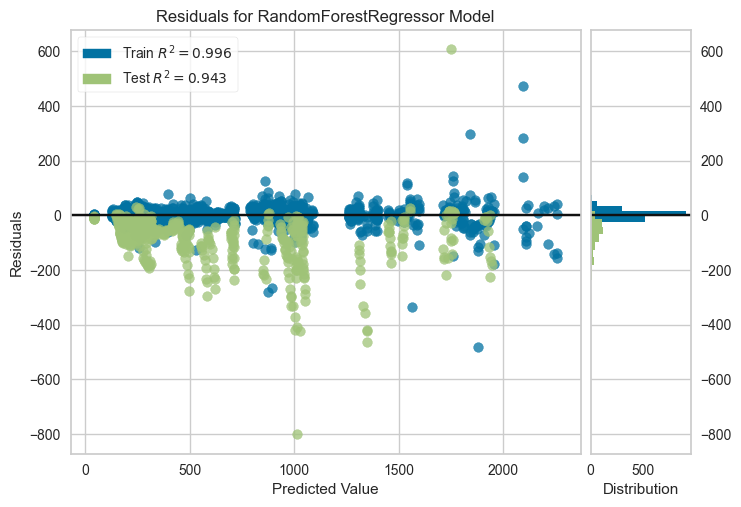

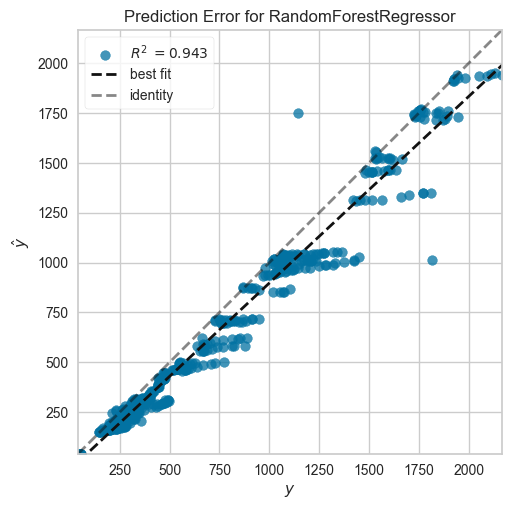

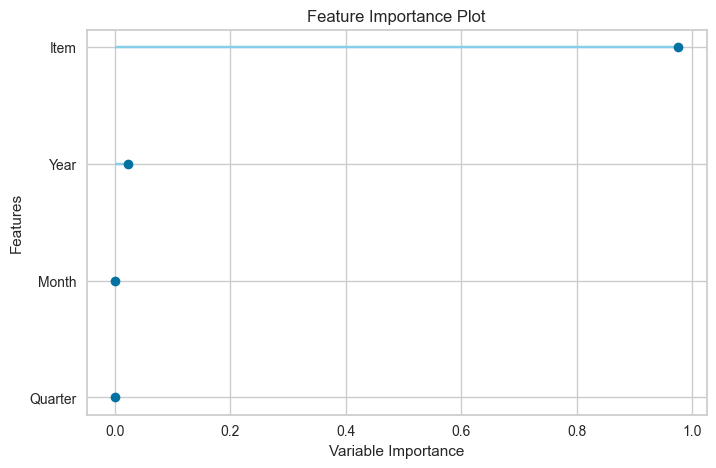

In [17]:
tuned_model = tune_model(best_model, optimize='RMSE')

# plot Residuals (actual - predicted)
plot_model(tuned_model, plot='residuals')

# plot Prediction error (actual vs predicted)
plot_model(tuned_model, plot='error')

# see importance features based on baseline model 
plot_model(tuned_model, plot='feature')


In [18]:
#create df for engineering
df_engineered = df_clean.copy()

#create flag to signal covid effect
df_engineered["Covid_Period"] = (
    ((df_engineered["Year"] > 2019) & (df_engineered["Year"] <= 2021)) |
    ((df_engineered["Year"] == 2019) & (df_engineered["Month"] >= 6))
).astype(int)

df_engineered.head()

,Item,Date,Price,Year,Month,Quarter,Covid_Period
0,Agric eggs medium size,2017-01-01,512.99,2017,1,1,0
1,Agric eggs(medium size price of one),2017-01-01,47.42,2017,1,1,0
2,"Beans brown,sold loose",2017-01-01,353.60,2017,1,1,0
3,Beans:white black eye. sold loose,2017-01-01,305.53,2017,1,1,0
4,Beef Bone in,2017-01-01,1001.24,2017,1,1,0


In [20]:
#make month and quarters cyclic so model doesnt see it as increasing order
def preprocess_features(df):
    #Keep Item as categorical
    df["Item"] = df["Item"].astype("category")

    # Month cyclical encoding
    df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
    df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

    # Quarter cyclical encoding
    df["Quarter_sin"] = np.sin(2 * np.pi * df["Quarter"] / 4)
    df["Quarter_cos"] = np.cos(2 * np.pi * df["Quarter"] / 4)

    # Keep Year and Covid_Period as numeric
    # Drop raw Month/Quarter to avoid redundancy
    # df = df.drop(columns=["Month", "Quarter"])

    return df

df_engineered = preprocess_features(df_engineered)
df_engineered.head()

,Item,Date,Price,Year,Month,Quarter,Covid_Period,Month_sin,Month_cos,Quarter_sin,Quarter_cos
0,Agric eggs medium size,2017-01-01,512.99,2017,1,1,0,0.5,0.866025,1.0,6.123234e-17
1,Agric eggs(medium size price of one),2017-01-01,47.42,2017,1,1,0,0.5,0.866025,1.0,6.123234e-17
2,"Beans brown,sold loose",2017-01-01,353.60,2017,1,1,0,0.5,0.866025,1.0,6.123234e-17
3,Beans:white black eye. sold loose,2017-01-01,305.53,2017,1,1,0,0.5,0.866025,1.0,6.123234e-17
4,Beef Bone in,2017-01-01,1001.24,2017,1,1,0,0.5,0.866025,1.0,6.123234e-17
